### ME3:

In [17]:
# Standard library imports
import os
import time
import json
from collections import defaultdict
from functools import wraps
from pathlib import Path
from typing import Dict, Iterable, Mapping, Tuple

# Third-party imports
import lightning as L
import torch
from einops import einsum
from torch.optim.lr_scheduler import MultiStepLR
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchvision.models import ResNet18_Weights, resnet18, ResNet
from torch import nn
from torchmetrics.classification import Accuracy
from torch.nn.utils import prune
from tqdm.auto import tqdm

# set precision for matmuls
torch.set_float32_matmul_precision("medium")   # or "medium"

# Resolve storage locations for local runs and Google Drive
def resolve_base_dir() -> Path:
    env_override = os.environ.get("AI231_BASE_DIR")
    if env_override:
        return Path(env_override).expanduser()

    cwd = Path.cwd()
    drive_root = Path("/content/drive/MyDrive")
    if drive_root.exists():
        try:
            cwd.relative_to(drive_root)
        except ValueError:
            project_dir = drive_root / "ai231"
            project_dir.mkdir(parents=True, exist_ok=True)
            return project_dir
        else:
            return cwd

    return cwd

BASE_DIR = resolve_base_dir()
DATA_ROOT = BASE_DIR / "data" / "CIFAR10"
ARTIFACT_DIR = BASE_DIR / "artifacts" / "me3"
CKPT_PATH = ARTIFACT_DIR / "resnet18_finetuned.ckpt"


In [18]:
class CustomResNet18(nn.Module):
    """ResNet18 backbone that exposes residual blocks for depth pruning workflows."""

    STAGE_NAMES = ("layer1", "layer2", "layer3", "layer4")

    def __init__(
        self,
        *,
        weights: ResNet18_Weights | None = ResNet18_Weights.IMAGENET1K_V1,
        block_keep_mask: Mapping[str, Iterable[int]] | None = None,
    ) -> None:
        super().__init__()
        base_model = resnet18(weights=weights)
        self.conv1 = base_model.conv1
        self.bn1 = base_model.bn1
        self.relu = base_model.relu
        self.maxpool = base_model.maxpool

        self.stages = nn.ModuleDict(
            {
                name: nn.ModuleList(list(getattr(base_model, name).children()))
                for name in self.STAGE_NAMES
            }
        )
        self.avgpool = base_model.avgpool
        self.fc = base_model.fc

        self.set_block_keep_mask(block_keep_mask)

    def set_block_keep_mask(
        self, block_keep_mask: Mapping[str, Iterable[int]] | None
    ) -> Dict[str, list[int]]:
        """Update which residual blocks should run for each stage."""
        validated = self._validate_mask(block_keep_mask)
        self.block_keep_mask = validated
        self._active_blocks = {name: set(indices) for name, indices in validated.items()}
        return validated

    def prune_blocks(self, layer_name: str, drop_indices: Iterable[int]) -> Dict[str, list[int]]:
        """Remove specific block indices from a stage and update the keep mask."""
        if layer_name not in self.STAGE_NAMES:
            raise ValueError(f"Unknown stage '{layer_name}'. Expected one of {self.STAGE_NAMES}.")

        drop = set(int(idx) for idx in drop_indices)
        current = [idx for idx in self.block_keep_mask[layer_name] if idx not in drop]
        updated_mask = dict(self.block_keep_mask)
        updated_mask[layer_name] = current
        return self.set_block_keep_mask(updated_mask)

    def forward_features(self, x: torch.Tensor) -> torch.Tensor:
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for stage_name in self.STAGE_NAMES:
            x = self._forward_stage(x, stage_name)

        x = self.avgpool(x)
        return torch.flatten(x, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.forward_features(x)
        return self.fc(x)

    def _forward_stage(self, x: torch.Tensor, stage_name: str) -> torch.Tensor:
        active_blocks = self._active_blocks[stage_name]
        for idx, block in enumerate(self.stages[stage_name]):
            if idx not in active_blocks:
                continue
            x = block(x)
        return x

    def _validate_mask(
        self, block_keep_mask: Mapping[str, Iterable[int]] | None
    ) -> Dict[str, list[int]]:
        validated: Dict[str, list[int]] = {}
        for stage_name in self.STAGE_NAMES:
            blocks = self.stages[stage_name]
            keep = block_keep_mask.get(stage_name) if block_keep_mask else None
            if keep is None:
                keep_indices = list(range(len(blocks)))
            else:
                keep_indices = sorted(set(int(idx) for idx in keep))

            if not keep_indices:
                raise ValueError(f"Stage '{stage_name}' must retain at least one block.")

            max_idx = len(blocks) - 1
            for idx in keep_indices:
                if idx < 0 or idx > max_idx:
                    raise ValueError(
                        f"Block index {idx} is out of bounds for stage '{stage_name}' (0..{max_idx})."
                    )

            first_block = blocks[0]
            if 0 not in keep_indices:
                needs_downsample = getattr(first_block, "downsample", None) is not None
                stride = getattr(first_block.conv1, "stride", (1, 1))
                if needs_downsample or stride[0] > 1:
                    raise ValueError(
                        f"Cannot drop block 0 from stage '{stage_name}' because it performs downsampling."
                    )

            validated[stage_name] = keep_indices
        return validated


In [19]:
weights_and_biases = ResNet18_Weights.DEFAULT.get_state_dict()
print(weights_and_biases.keys())

odict_keys(['conv1.weight', 'bn1.running_mean', 'bn1.running_var', 'bn1.weight', 'bn1.bias', 'layer1.0.conv1.weight', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.conv2.weight', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.1.conv1.weight', 'layer1.1.bn1.running_mean', 'layer1.1.bn1.running_var', 'layer1.1.bn1.weight', 'layer1.1.bn1.bias', 'layer1.1.conv2.weight', 'layer1.1.bn2.running_mean', 'layer1.1.bn2.running_var', 'layer1.1.bn2.weight', 'layer1.1.bn2.bias', 'layer2.0.conv1.weight', 'layer2.0.bn1.running_mean', 'layer2.0.bn1.running_var', 'layer2.0.bn1.weight', 'layer2.0.bn1.bias', 'layer2.0.conv2.weight', 'layer2.0.bn2.running_mean', 'layer2.0.bn2.running_var', 'layer2.0.bn2.weight', 'layer2.0.bn2.bias', 'layer2.0.downsample.0.weight', 'layer2.0.downsample.1.running_mean', 'layer2.0.downsample.1.running_var', 'layer2.0.downsample.1.weight', 'layer2.0.do

In [20]:
weights_and_biases['fc.weight']

Parameter containing:
tensor([[-0.0185, -0.0705, -0.0518,  ..., -0.0390,  0.1735, -0.0410],
        [-0.0818, -0.0944,  0.0174,  ...,  0.2028, -0.0248,  0.0372],
        [-0.0332, -0.0566, -0.0242,  ..., -0.0344, -0.0227,  0.0197],
        ...,
        [-0.0103,  0.0033, -0.0359,  ..., -0.0279, -0.0115,  0.0128],
        [-0.0359, -0.0353, -0.0296,  ..., -0.0330, -0.0110, -0.0513],
        [ 0.0021, -0.0248, -0.0829,  ...,  0.0417, -0.0500,  0.0663]],
       requires_grad=True)

#### Load the Datasets

In [32]:
class CIFAR10DataModule(L.LightningDataModule):
    def __init__(
            self, 
            data_dir: str = "data/CIFAR10", 
            batch_size: int = 256, 
            num_workers: int = 0
        ):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

    def setup(self, stage: str | None = None):
        self.generator = torch.Generator().manual_seed(42)

        if stage in (None, 'fit', 'validate'):
            cifar10_full = CIFAR10(
                root=self.data_dir,
                train=True,
                transform=self.transform,
                download=True,
            )
            self.cifar10_train, self.cifar10_val = random_split(
                cifar10_full, [47500, 2500], generator=self.generator
            )
        
        if stage in (None, "test", "predict"):
            self.cifar10_test = CIFAR10(
                root=self.data_dir,
                train=False,
                transform=self.transform,
                download=True,
            )

    def train_dataloader(self):
        return DataLoader(
            self.cifar10_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
            persistent_workers=False,
            pin_memory=True,
            drop_last=True,
        )

    def val_dataloader(self):
        return DataLoader(
            self.cifar10_val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=0,
            pin_memory=True,
            persistent_workers=False,
        )

    def test_dataloader(self):
        return DataLoader(
            self.cifar10_test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
            pin_memory=True,
            persistent_workers=self.num_workers > 0,
        )


#### Initialize the model and replace head

In [30]:
class LitResnet18(L.LightningModule):
    def __init__(
        self,
        num_classes: int = 10,
        lr: float = 1e-3,
        *,
        block_keep_mask: Mapping[str, Iterable[int]] | None = None,
        train_backbone: bool = False,
    ) -> None:
        super().__init__()
        sanitized_mask = None
        if block_keep_mask is not None:
            sanitized_mask = {}
            for stage_name, indices in block_keep_mask.items():
                if stage_name not in CustomResNet18.STAGE_NAMES:
                    raise ValueError(
                        f"Stage '{stage_name}' is invalid. Expected one of {CustomResNet18.STAGE_NAMES}."
                    )
                sanitized_mask[stage_name] = [int(idx) for idx in sorted(set(indices))]

        self.save_hyperparameters(
            {
                "num_classes": num_classes,
                "lr": lr,
                "block_keep_mask": sanitized_mask,
                "train_backbone": train_backbone,
            }
        )

        self.model = CustomResNet18(
            weights=ResNet18_Weights.IMAGENET1K_V1,
            block_keep_mask=sanitized_mask,
        )
        self.model.fc = nn.Linear(512, num_classes)

        if not train_backbone:
            for name, param in self.model.named_parameters():
                if not name.startswith("fc"):
                    param.requires_grad = False

        self.loss = nn.CrossEntropyLoss()
        self.val_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.test_acc = Accuracy(task="multiclass", num_classes=num_classes)
        self.train_acc = Accuracy(task="multiclass", num_classes=num_classes)

    def prune_backbone_blocks(self, layer_name: str, drop_indices: Iterable[int]) -> Dict[str, list[int]]:
        """Prune backbone blocks and keep hyperparameters in sync."""
        updated = self.model.prune_blocks(layer_name, drop_indices)
        self.hparams.block_keep_mask = {name: list(indices) for name, indices in updated.items()}
        return updated

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.model(x)

    def _shared_step(self, batch, batch_idx) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        x, y = batch
        logits = self(x)
        loss = self.loss(logits, y)
        preds = torch.argmax(logits, dim=1)
        return loss, preds, y

    def training_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch, batch_idx)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("train_acc", self.train_acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch, batch_idx)
        self.val_acc.update(preds, y)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("val_acc", self.val_acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def test_step(self, batch, batch_idx):
        loss, preds, y = self._shared_step(batch, batch_idx)
        self.test_acc.update(preds, y)
        self.log("test_loss", loss, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)
        self.log("test_acc", self.test_acc, on_step=False, on_epoch=True, prog_bar=True, sync_dist=True)

    def configure_optimizers(self):
        trainable = (param for param in self.parameters() if param.requires_grad)
        optimizer = torch.optim.SGD(
            trainable, lr=self.hparams.lr, momentum=0.9, weight_decay=1e-4
        )
        scheduler = MultiStepLR(optimizer, milestones=[30, 60], gamma=0.1)
        return {
            "optimizer": optimizer,
            "lr_scheduler": {
                "scheduler": scheduler,
                "interval": "epoch",
                "frequency": 1,
            }
        }


#### Initial training of new head

In [33]:
ckpt_path = CKPT_PATH
ckpt_path.parent.mkdir(parents=True, exist_ok=True)

cifar10_dm = CIFAR10DataModule(num_workers=0)

if ckpt_path.exists():
    print(f"Loading {ckpt_path}")
    model = LitResnet18.load_from_checkpoint(ckpt_path)
else:
    print("No checkpoint found; training a new model.")
    model = LitResnet18()
    trainer = L.Trainer(max_epochs=10)
    trainer.fit(model, datamodule=cifar10_dm)
    trainer.save_checkpoint(ckpt_path)



No checkpoint found; training a new model.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CustomResNet18     | 11.2 M | train
1 | loss      | CrossEntropyLoss   | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | train_acc | MulticlassAccuracy | 0      | train
---------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 9: 100%|██████████| 185/185 [01:54<00:00,  1.61it/s, v_num=34, train_loss_step=0.670, val_loss=0.698, val_acc=0.764, train_loss_epoch=0.687, train_acc=0.768]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 185/185 [01:54<00:00,  1.61it/s, v_num=34, train_loss_step=0.670, val_loss=0.698, val_acc=0.764, train_loss_epoch=0.687, train_acc=0.768]


In [24]:
def summarize_backbone_blocks(lit_model: LitResnet18) -> Dict[str, tuple[int, int]]:
    """Return (active, total) block counts for each residual stage."""
    summary: Dict[str, tuple[int, int]] = {}
    backbone = lit_model.model
    for stage_name in CustomResNet18.STAGE_NAMES:
        total = len(backbone.stages[stage_name])
        active = len(backbone.block_keep_mask[stage_name])
        summary[stage_name] = (active, total)
    return summary

def prune_backbone_blocks(
    lit_model: LitResnet18,
    layer_name: str,
    drop_indices: Iterable[int],
) -> Dict[str, list[int]]:
    """Prune residual blocks in-place and report the updated keep mask."""
    updated = lit_model.prune_backbone_blocks(layer_name, drop_indices)
    active = updated[layer_name]
    print(f"Active blocks for {layer_name}: {active}")
    return updated

# Example usage after loading a checkpoint
if 'model' in globals():
    summarize_backbone_blocks(model)
    # prune_backbone_blocks(model, "layer3", [1])


#### Testing accuracy following the new head

In [25]:
# Evaluate the fine-tuned head on the held-out test set
eval_trainer = L.Trainer()
test_results = eval_trainer.test(model, datamodule=cifar10_dm, verbose=False)

if test_results:
    metrics = test_results[0]
    test_acc = metrics.get("test_acc")
    if test_acc is not None:
        print(f"Test Accuracy: {test_acc:.4f}")
    print(metrics)


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 40/40 [00:22<00:00,  1.79it/s]
Test Accuracy: 0.7770
{'test_loss': 0.6564152240753174, 'test_acc': 0.7770000100135803}


Yes—around 60 cycles is a sensible upper bound if you keep pruning 5 % of the remaining head weights per cycle.

Here’s why:

With s = 0.05 per cycle, total sparsity after n cycles is

1−0.95n
1−0.95
n

So:

20 cycles → ~64 % total sparsity

40 cycles → ~87 % total sparsity

60 cycles → ~95 % total sparsity

95 % total sparsity is right at the range where most ResNet-18 heads can no longer recover validation accuracy.
Beyond that, recovery is usually negligible and training time is wasted.

Going much past 60 cycles gives very small additional pruning (e.g., 80 cycles only brings you to ~98 % sparsity) and very low accuracy.

#### Prune cycle

In [26]:
artifact_dir = ARTIFACT_DIR
artifact_dir.mkdir(parents=True, exist_ok=True)
results_path = artifact_dir / "depth_pruning_results.json"
checkpoint_template = "depth_cycle_{:02d}.ckpt"

stage_order = ("layer4", "layer3", "layer2", "layer1")
max_additional_cycles = 12
prune_epochs = 5

if results_path.exists():
    results = json.loads(results_path.read_text())
    results.sort(key=lambda entry: entry.get("cycle", 0))
else:
    results = []

completed_cycles = {entry["cycle"] for entry in results if "cycle" in entry}

if completed_cycles:
    last_cycle = max(completed_cycles)
    resume_ckpt = artifact_dir / checkpoint_template.format(last_cycle)
    if resume_ckpt.exists():
        print(f"Resuming from {resume_ckpt}")
        model = LitResnet18.load_from_checkpoint(resume_ckpt)
    else:
        print(f"Checkpoint {resume_ckpt} not found; reapplying recorded pruning schedule.")
        for record in results:
            stage = record.get("stage")
            pruned_block = record.get("pruned_block")
            if stage is None or pruned_block is None:
                continue
            current_keep = model.model.block_keep_mask[stage]
            if pruned_block in current_keep:
                model.prune_backbone_blocks(stage, [pruned_block])


def next_prune_target(backbone: CustomResNet18) -> tuple[str | None, int | None]:
    for stage_name in stage_order:
        keep = backbone.block_keep_mask[stage_name]
        removable = [idx for idx in keep if idx != 0]
        if removable:
            return stage_name, removable[-1]
    return None, None


def capture_keep_mask(backbone: CustomResNet18) -> Dict[str, list[int]]:
    return {name: list(indices) for name, indices in backbone.block_keep_mask.items()}


def total_remaining_prunable_blocks(backbone: CustomResNet18) -> int:
    total = 0
    for stage_name in stage_order:
        keep = backbone.block_keep_mask[stage_name]
        total += max(0, len(keep) - 1)
    return total

remaining_blocks = total_remaining_prunable_blocks(model.model)
if remaining_blocks == 0:
    print("No more removable blocks available; depth pruning already complete.")
else:
    cycles_to_execute = min(max_additional_cycles, remaining_blocks)
    cycles_run = 0

    while cycles_run < cycles_to_execute:
        next_cycle = max(completed_cycles) + 1 if completed_cycles else 1
        stage_name, block_idx = next_prune_target(model.model)
        if stage_name is None:
            print("No more eligible blocks to prune; stopping depth pruning.")
            break

        print(f"Cycle {next_cycle:02d}: pruning block {block_idx} from {stage_name}.")
        model.prune_backbone_blocks(stage_name, [block_idx])

        prune_trainer = L.Trainer(max_epochs=prune_epochs)
        prune_trainer.fit(model, datamodule=cifar10_dm)
        val_metrics = prune_trainer.validate(model, datamodule=cifar10_dm, verbose=False)
        val_acc = float(val_metrics[0]["val_acc"]) if val_metrics else None

        record = {
            "cycle": next_cycle,
            "stage": stage_name,
            "pruned_block": block_idx,
            "val_acc": val_acc,
            "keep_mask": capture_keep_mask(model.model),
        }
        results.append(record)
        completed_cycles.add(next_cycle)
        cycles_run += 1

        ckpt_path = artifact_dir / checkpoint_template.format(next_cycle)
        prune_trainer.save_checkpoint(ckpt_path)
        results_path.write_text(json.dumps(results, indent=2))

        model = prune_trainer.lightning_module
        remaining_blocks = total_remaining_prunable_blocks(model.model)
        if remaining_blocks == 0:
            print("No more removable blocks available; depth pruning complete.")
            break

    if remaining_blocks > 0:
        print(f"Remaining removable blocks: {remaining_blocks}")


Cycle 01: pruning block 1 from layer4.


💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CustomResNet18     | 11.2 M | train
1 | loss      | CrossEntropyLoss   | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | train_acc | MulticlassAccuracy | 0      | train
---------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 175/175 [01:58<00:00,  1.47it/s, v_num=29, train_loss_step=1.960, val_loss=1.950, val_acc=0.665, train_loss_epoch=1.960, train_acc=0.667]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 175/175 [01:58<00:00,  1.47it/s, v_num=29, train_loss_step=1.960, val_loss=1.950, val_acc=0.665, train_loss_epoch=1.960, train_acc=0.667]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 20/20 [00:11<00:00,  1.79it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Cycle 02: pruning block 1 from layer3.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CustomResNet18     | 11.2 M | train
1 | loss      | CrossEntropyLoss   | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | train_acc | MulticlassAccuracy | 0      | train
---------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 175/175 [01:51<00:00,  1.57it/s, v_num=30, train_loss_step=1.830, val_loss=1.830, val_acc=0.599, train_loss_epoch=1.840, train_acc=0.602]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 175/175 [01:51<00:00,  1.57it/s, v_num=30, train_loss_step=1.830, val_loss=1.830, val_acc=0.599, train_loss_epoch=1.840, train_acc=0.602]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 20/20 [00:11<00:00,  1.81it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



Cycle 03: pruning block 1 from layer2.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CustomResNet18     | 11.2 M | train
1 | loss      | CrossEntropyLoss   | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | train_acc | MulticlassAccuracy | 0      | train
---------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 175/175 [01:54<00:00,  1.52it/s, v_num=31, train_loss_step=1.780, val_loss=1.770, val_acc=0.535, train_loss_epoch=1.790, train_acc=0.539]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 175/175 [01:55<00:00,  1.52it/s, v_num=31, train_loss_step=1.780, val_loss=1.770, val_acc=0.535, train_loss_epoch=1.790, train_acc=0.539]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 20/20 [00:10<00:00,  1.85it/s]

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.



Cycle 04: pruning block 1 from layer1.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CustomResNet18     | 11.2 M | train
1 | loss      | CrossEntropyLoss   | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
4 | train_acc | MulticlassAccuracy | 0      | train
---------------------------------------------------------
5.1 K     Trainable params
11.2 M    Non-trainable params
11.2 M    Total params
44.727    Total estimated model params size (MB)
73        Modules in train mode
0         Modules in eval mode


Epoch 4: 100%|██████████| 175/175 [01:47<00:00,  1.63it/s, v_num=32, train_loss_step=1.750, val_loss=1.770, val_acc=0.493, train_loss_epoch=1.780, train_acc=0.484]

`Trainer.fit` stopped: `max_epochs=5` reached.


Epoch 4: 100%|██████████| 175/175 [01:47<00:00,  1.62it/s, v_num=32, train_loss_step=1.750, val_loss=1.770, val_acc=0.493, train_loss_epoch=1.780, train_acc=0.484]


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation DataLoader 0: 100%|██████████| 20/20 [00:10<00:00,  1.87it/s]
No more removable blocks available; depth pruning complete.


#### Plot the performance-#pruning curve

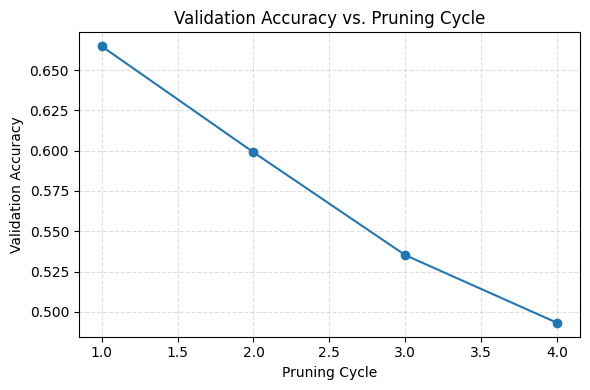

In [27]:
# Plot validation accuracy against pruning cycle
import matplotlib.pyplot as plt

if 'results_path' in globals() and results_path.exists():
    pruning_history = json.loads(results_path.read_text())
elif 'results' in globals():
    pruning_history = results
else:
    pruning_history = []

if not pruning_history:
    print('No pruning results available yet. Run the pruning loop first.')
else:
    cycles = [entry['cycle'] for entry in pruning_history]
    val_accs = [entry['val_acc'] for entry in pruning_history]

    plt.figure(figsize=(6, 4))
    plt.plot(cycles, val_accs, marker='o')
    plt.xlabel('Pruning Cycle')
    plt.ylabel('Validation Accuracy')
    plt.title('Validation Accuracy vs. Pruning Cycle')
    plt.grid(True, linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()


#### Test the pruned model

In [28]:
# Evaluate the checkpoint recorded just before the steepest validation drop
if 'results_path' in globals() and results_path.exists():
    pruning_history = json.loads(results_path.read_text())
elif 'results' in globals():
    pruning_history = results
else:
    pruning_history = []

if len(pruning_history) < 2:
    print('Need at least two pruning cycles to analyze drops.')
else:
    deltas = []
    for prev, curr in zip(pruning_history, pruning_history[1:]):
        delta = curr['val_acc'] - prev['val_acc']
        deltas.append((delta, prev['cycle'], curr['cycle']))

    steepest_drop = min(deltas, key=lambda item: item[0])
    drop_value, before_cycle, after_cycle = steepest_drop
    if drop_value >= 0:
        print('Validation accuracy never decreased; nothing to evaluate.')
    else:
        target_cycle = before_cycle
        print(f"Steepest drop: {drop_value:.4f} between cycles {before_cycle} -> {after_cycle}.")
        ckpt_path = ARTIFACT_DIR / f"cycle_{target_cycle:02d}.ckpt"
        if not ckpt_path.exists():
            print(f"Checkpoint {ckpt_path} not found.")
        else:
            eval_model = LitResnet18.load_from_checkpoint(ckpt_path)
            eval_model.eval()
            eval_trainer = L.Trainer()
            test_metrics = eval_trainer.test(eval_model, datamodule=cifar10_dm, verbose=False)
            if test_metrics:
                metrics = test_metrics[0]
                test_acc = metrics.get('test_acc')
                if test_acc is not None:
                    print(f"Test accuracy before drop (cycle {target_cycle:02d}): {test_acc:.4f}")
                print(metrics)


Steepest drop: -0.0658 between cycles 1 -> 2.


RuntimeError: Error(s) in loading state_dict for LitResnet18:
	Missing key(s) in state_dict: "model.stages.layer1.0.conv1.weight", "model.stages.layer1.0.bn1.weight", "model.stages.layer1.0.bn1.bias", "model.stages.layer1.0.bn1.running_mean", "model.stages.layer1.0.bn1.running_var", "model.stages.layer1.0.conv2.weight", "model.stages.layer1.0.bn2.weight", "model.stages.layer1.0.bn2.bias", "model.stages.layer1.0.bn2.running_mean", "model.stages.layer1.0.bn2.running_var", "model.stages.layer1.1.conv1.weight", "model.stages.layer1.1.bn1.weight", "model.stages.layer1.1.bn1.bias", "model.stages.layer1.1.bn1.running_mean", "model.stages.layer1.1.bn1.running_var", "model.stages.layer1.1.conv2.weight", "model.stages.layer1.1.bn2.weight", "model.stages.layer1.1.bn2.bias", "model.stages.layer1.1.bn2.running_mean", "model.stages.layer1.1.bn2.running_var", "model.stages.layer2.0.conv1.weight", "model.stages.layer2.0.bn1.weight", "model.stages.layer2.0.bn1.bias", "model.stages.layer2.0.bn1.running_mean", "model.stages.layer2.0.bn1.running_var", "model.stages.layer2.0.conv2.weight", "model.stages.layer2.0.bn2.weight", "model.stages.layer2.0.bn2.bias", "model.stages.layer2.0.bn2.running_mean", "model.stages.layer2.0.bn2.running_var", "model.stages.layer2.0.downsample.0.weight", "model.stages.layer2.0.downsample.1.weight", "model.stages.layer2.0.downsample.1.bias", "model.stages.layer2.0.downsample.1.running_mean", "model.stages.layer2.0.downsample.1.running_var", "model.stages.layer2.1.conv1.weight", "model.stages.layer2.1.bn1.weight", "model.stages.layer2.1.bn1.bias", "model.stages.layer2.1.bn1.running_mean", "model.stages.layer2.1.bn1.running_var", "model.stages.layer2.1.conv2.weight", "model.stages.layer2.1.bn2.weight", "model.stages.layer2.1.bn2.bias", "model.stages.layer2.1.bn2.running_mean", "model.stages.layer2.1.bn2.running_var", "model.stages.layer3.0.conv1.weight", "model.stages.layer3.0.bn1.weight", "model.stages.layer3.0.bn1.bias", "model.stages.layer3.0.bn1.running_mean", "model.stages.layer3.0.bn1.running_var", "model.stages.layer3.0.conv2.weight", "model.stages.layer3.0.bn2.weight", "model.stages.layer3.0.bn2.bias", "model.stages.layer3.0.bn2.running_mean", "model.stages.layer3.0.bn2.running_var", "model.stages.layer3.0.downsample.0.weight", "model.stages.layer3.0.downsample.1.weight", "model.stages.layer3.0.downsample.1.bias", "model.stages.layer3.0.downsample.1.running_mean", "model.stages.layer3.0.downsample.1.running_var", "model.stages.layer3.1.conv1.weight", "model.stages.layer3.1.bn1.weight", "model.stages.layer3.1.bn1.bias", "model.stages.layer3.1.bn1.running_mean", "model.stages.layer3.1.bn1.running_var", "model.stages.layer3.1.conv2.weight", "model.stages.layer3.1.bn2.weight", "model.stages.layer3.1.bn2.bias", "model.stages.layer3.1.bn2.running_mean", "model.stages.layer3.1.bn2.running_var", "model.stages.layer4.0.conv1.weight", "model.stages.layer4.0.bn1.weight", "model.stages.layer4.0.bn1.bias", "model.stages.layer4.0.bn1.running_mean", "model.stages.layer4.0.bn1.running_var", "model.stages.layer4.0.conv2.weight", "model.stages.layer4.0.bn2.weight", "model.stages.layer4.0.bn2.bias", "model.stages.layer4.0.bn2.running_mean", "model.stages.layer4.0.bn2.running_var", "model.stages.layer4.0.downsample.0.weight", "model.stages.layer4.0.downsample.1.weight", "model.stages.layer4.0.downsample.1.bias", "model.stages.layer4.0.downsample.1.running_mean", "model.stages.layer4.0.downsample.1.running_var", "model.stages.layer4.1.conv1.weight", "model.stages.layer4.1.bn1.weight", "model.stages.layer4.1.bn1.bias", "model.stages.layer4.1.bn1.running_mean", "model.stages.layer4.1.bn1.running_var", "model.stages.layer4.1.conv2.weight", "model.stages.layer4.1.bn2.weight", "model.stages.layer4.1.bn2.bias", "model.stages.layer4.1.bn2.running_mean", "model.stages.layer4.1.bn2.running_var", "model.fc.weight". 
	Unexpected key(s) in state_dict: "model.layer1.0.conv1.weight", "model.layer1.0.bn1.weight", "model.layer1.0.bn1.bias", "model.layer1.0.bn1.running_mean", "model.layer1.0.bn1.running_var", "model.layer1.0.bn1.num_batches_tracked", "model.layer1.0.conv2.weight", "model.layer1.0.bn2.weight", "model.layer1.0.bn2.bias", "model.layer1.0.bn2.running_mean", "model.layer1.0.bn2.running_var", "model.layer1.0.bn2.num_batches_tracked", "model.layer1.1.conv1.weight", "model.layer1.1.bn1.weight", "model.layer1.1.bn1.bias", "model.layer1.1.bn1.running_mean", "model.layer1.1.bn1.running_var", "model.layer1.1.bn1.num_batches_tracked", "model.layer1.1.conv2.weight", "model.layer1.1.bn2.weight", "model.layer1.1.bn2.bias", "model.layer1.1.bn2.running_mean", "model.layer1.1.bn2.running_var", "model.layer1.1.bn2.num_batches_tracked", "model.layer2.0.conv1.weight", "model.layer2.0.bn1.weight", "model.layer2.0.bn1.bias", "model.layer2.0.bn1.running_mean", "model.layer2.0.bn1.running_var", "model.layer2.0.bn1.num_batches_tracked", "model.layer2.0.conv2.weight", "model.layer2.0.bn2.weight", "model.layer2.0.bn2.bias", "model.layer2.0.bn2.running_mean", "model.layer2.0.bn2.running_var", "model.layer2.0.bn2.num_batches_tracked", "model.layer2.0.downsample.0.weight", "model.layer2.0.downsample.1.weight", "model.layer2.0.downsample.1.bias", "model.layer2.0.downsample.1.running_mean", "model.layer2.0.downsample.1.running_var", "model.layer2.0.downsample.1.num_batches_tracked", "model.layer2.1.conv1.weight", "model.layer2.1.bn1.weight", "model.layer2.1.bn1.bias", "model.layer2.1.bn1.running_mean", "model.layer2.1.bn1.running_var", "model.layer2.1.bn1.num_batches_tracked", "model.layer2.1.conv2.weight", "model.layer2.1.bn2.weight", "model.layer2.1.bn2.bias", "model.layer2.1.bn2.running_mean", "model.layer2.1.bn2.running_var", "model.layer2.1.bn2.num_batches_tracked", "model.layer3.0.conv1.weight", "model.layer3.0.bn1.weight", "model.layer3.0.bn1.bias", "model.layer3.0.bn1.running_mean", "model.layer3.0.bn1.running_var", "model.layer3.0.bn1.num_batches_tracked", "model.layer3.0.conv2.weight", "model.layer3.0.bn2.weight", "model.layer3.0.bn2.bias", "model.layer3.0.bn2.running_mean", "model.layer3.0.bn2.running_var", "model.layer3.0.bn2.num_batches_tracked", "model.layer3.0.downsample.0.weight", "model.layer3.0.downsample.1.weight", "model.layer3.0.downsample.1.bias", "model.layer3.0.downsample.1.running_mean", "model.layer3.0.downsample.1.running_var", "model.layer3.0.downsample.1.num_batches_tracked", "model.layer3.1.conv1.weight", "model.layer3.1.bn1.weight", "model.layer3.1.bn1.bias", "model.layer3.1.bn1.running_mean", "model.layer3.1.bn1.running_var", "model.layer3.1.bn1.num_batches_tracked", "model.layer3.1.conv2.weight", "model.layer3.1.bn2.weight", "model.layer3.1.bn2.bias", "model.layer3.1.bn2.running_mean", "model.layer3.1.bn2.running_var", "model.layer3.1.bn2.num_batches_tracked", "model.layer4.0.conv1.weight", "model.layer4.0.bn1.weight", "model.layer4.0.bn1.bias", "model.layer4.0.bn1.running_mean", "model.layer4.0.bn1.running_var", "model.layer4.0.bn1.num_batches_tracked", "model.layer4.0.conv2.weight", "model.layer4.0.bn2.weight", "model.layer4.0.bn2.bias", "model.layer4.0.bn2.running_mean", "model.layer4.0.bn2.running_var", "model.layer4.0.bn2.num_batches_tracked", "model.layer4.0.downsample.0.weight", "model.layer4.0.downsample.1.weight", "model.layer4.0.downsample.1.bias", "model.layer4.0.downsample.1.running_mean", "model.layer4.0.downsample.1.running_var", "model.layer4.0.downsample.1.num_batches_tracked", "model.layer4.1.conv1.weight", "model.layer4.1.bn1.weight", "model.layer4.1.bn1.bias", "model.layer4.1.bn1.running_mean", "model.layer4.1.bn1.running_var", "model.layer4.1.bn1.num_batches_tracked", "model.layer4.1.conv2.weight", "model.layer4.1.bn2.weight", "model.layer4.1.bn2.bias", "model.layer4.1.bn2.running_mean", "model.layer4.1.bn2.running_var", "model.layer4.1.bn2.num_batches_tracked", "model.fc.weight_orig", "model.fc.weight_mask". 